# Tuning The Model

In [1]:
import glob, os
import numpy as np
from matplotlib import pyplot as plt
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, interval

We define necessary functions:

In [2]:
def get_stream_from_midi_without_drums(midi_path):
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    
    for i in range(len(mf.tracks)):
        mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

def stream_to_array_of_pitches_strings (stream):
    result = []
    for element in stream.flat.notes:
        stringRepresentationOfElement = ''
        if isinstance(element, note.Note):
            stringRepresentationOfElement = element.pitch.ps
        else: # it's a chord
            stringRepresentationOfElement = [note.pitch.ps for note in element.notes][0]
            #stringRepresentationOfElement = ' '.join(listOfNotesWithOctaves)
        result.append(stringRepresentationOfElement)
    return result

def from_midi_to_array_of_pitches (midi_path):
    return stream_to_array_of_pitches_strings(get_stream_from_midi_without_drums(midi_path))

def from_pitches_to_intervals (array_of_pitches):
    intervals = []
    for i in range(1,len(array_of_pitches) - 1):
        intervals.append(array_of_pitches[i] - array_of_pitches[i-1])
    return intervals

def from_midi_to_array_of_intervals(midi_path):
    return from_pitches_to_intervals(from_midi_to_array_of_pitches(midi_path))

def get_folder_songs_intervals(folder_path):
    songs = []
    for file in glob.glob(folder_path):
        songs.append(from_midi_to_array_of_intervals(file))
    return songs

def from_array_of_intervals_to_pitches (root_pitch, intervals):
    pitches = [root_pitch]
    for interval in intervals:
        pitches.append(pitches[-1] + interval)
    return pitches

def from_pitches_to_midi (pitches, midi_path):
    streamResult = stream.Stream()
    for pitch in pitches:
            streamResult.append(note.Note(pitch))
            
    streamResult.write('midi', fp= midi_path)
    
def from_intervals_to_midi( root_pitch, intervals, midi_path):
    pitches = from_array_of_intervals_to_pitches(root_pitch, intervals)
    from_pitches_to_midi(pitches, midi_path)


In [3]:
#Test
from_intervals_to_midi(60, from_midi_to_array_of_intervals('data/examples/silent_night_easy.mid'),'test_intervals_silent_night.mid') 

We prepare the data:

In [4]:
songs = get_folder_songs_intervals("data/examples/*.mid")

interval_to_number = {}
number_to_interval = {}

for song in songs:
    for element in song:
        if not element in interval_to_number:
            number_to_interval[len(interval_to_number)+1] = element
            interval_to_number[element] = len(interval_to_number)+1

In [5]:
[interval_to_number[element] for element in songs[0]][:10]

[1, 2, 3, 1, 2, 3, 1, 2, 3, 2]

In [6]:
train_set = [[interval_to_number[element] for element in song] for song in songs]

In [7]:
def slice_sequence_examples(sequence, num_steps):
    """Slice a sequence into redundant sequences of lenght num_steps."""
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_singleton_format(examples):
    """
    Return the examples in seq to singleton format.
    """
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)

In [13]:
SEQ_LEN = 30
BATCH_SIZE = 64
HIDDEN_UNITS = 256
EPOCHS = 50
VOCABULARY_SIZE = len(interval_to_number) + 1

In [70]:
VOCABULARY_SIZE

131

In [59]:
# Slice the sequences:
slices = []
for seq in train_set:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)

# Split the sequences into Xs and ys:
X, y = seq_to_singleton_format(slices)
# Convert into numpy arrays.
X = np.array(X)
y = np.array(y)

In [63]:
X.shape

(114790, 30)

We build the model:

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jvela\miniconda3\envs\dathoven\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jvela\miniconda3\envs\dath

In [61]:
print('Build model...')
model_interval = Sequential()
model_interval.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN, mask_zero=True))

# LSTM part
model_interval.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_interval.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_interval.add(Dense(VOCABULARY_SIZE, activation='softmax'))
model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model_interval.summary()

Build model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 256)           33536     
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_5 (Dense)              (None, 131)               33667     
Total params: 1,117,827
Trainable params: 1,117,827
Non-trainable params: 0
_________________________________________________________________


In [62]:
# checkpoint
filepath="models_checkpoints/weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [67]:
# Fit the model
history = model_interval.fit(X, y, validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list)


Train on 103311 samples, validate on 11479 samples
Epoch 1/50
103311/103311 [==============================] - 1083s 10ms/step - loss: 1.1558 - sparse_categorical_accuracy: 0.6927 - val_loss: 3.2842 - val_sparse_categorical_accuracy: 0.2520

Epoch 00001: saving model to models_checkpoints/weights-improvement-01-0.25.hdf5
Epoch 2/50
103311/103311 [==============================] - 1080s 10ms/step - loss: 0.9463 - sparse_categorical_accuracy: 0.7493 - val_loss: 3.5013 - val_sparse_categorical_accuracy: 0.2356

Epoch 00002: saving model to models_checkpoints/weights-improvement-02-0.24.hdf5
Epoch 3/50
 21056/103311 [=====>........................] - ETA: 13:33 - loss: 0.6997 - sparse_categorical_accuracy: 0.8227

KeyboardInterrupt: 

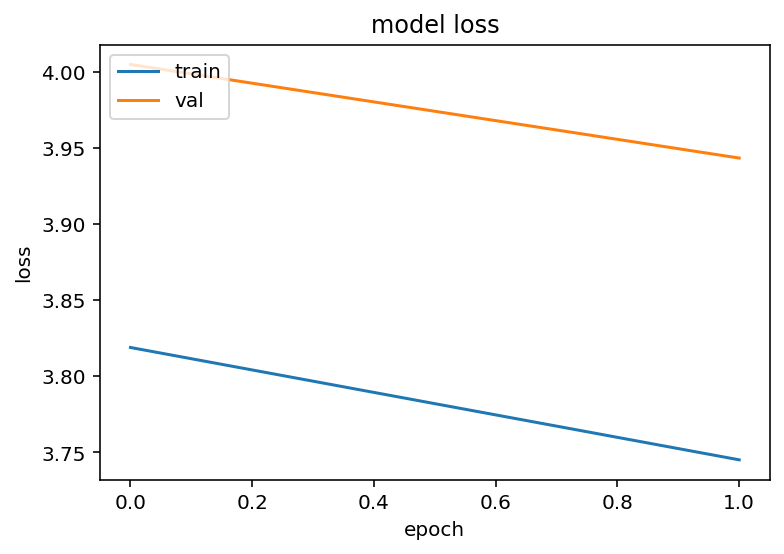

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#model_train.save("model-weights.h5")

We sample:

In [9]:
from random import randint
def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]

In [10]:
def sample_seq( seq, seq_length, model, number_to_note, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = pad_sequences(input_sequence, maxlen = seq_length, padding="pre")
        prediction = model.predict(x)
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

In [52]:
generated_vector = sample_seq([1], SEQ_LEN, model_interval, number_to_interval, 50)
generated_intervals = [number_to_interval[number] for number in generated_vector]


In [53]:
from_intervals_to_midi(70, generated_intervals,'generated_record_intervals_tuning.mid') 

Probando map (mean average precission): 

In [11]:
from keras.metrics import Precision
from keras.metrics import SparseTopKCategoricalAccuracy

In [16]:

HIDDEN_UNITS = 50
EPOCHS = 50
VOCABULARY_SIZE = len(interval_to_number) + 1

In [17]:
print('Build model...')
model_interval = Sequential()
model_interval.add(Embedding(VOCABULARY_SIZE, HIDDEN_UNITS, input_length=SEQ_LEN, mask_zero=True))

# LSTM part
model_interval.add(LSTM(HIDDEN_UNITS, return_sequences=True))
model_interval.add(LSTM(HIDDEN_UNITS))

# Project back to vocabulary
model_interval.add(Dense(VOCABULARY_SIZE, activation='softmax'))
#model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])#metrics=[Precision(top_k=10)])
#model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[Precision(top_k=10)])
model_interval.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[SparseTopKCategoricalAccuracy(k=10, name='sparse_top_k_categorical_accuracy')])


model_interval.summary()

Build model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            6550      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 131)               6681      
Total params: 53,631
Trainable params: 53,631
Non-trainable params: 0
_________________________________________________________________


In [90]:
# checkpoint
filepath="models_checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

In [91]:
# Fit the model
history = model_interval.fit(X, y, validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list)


Train on 103311 samples, validate on 11479 samples
Epoch 1/50
103311/103311 [==============================] - 235s 2ms/step - loss: 3.8718 - sparse_top_k_categorical_accuracy: 0.4538 - val_loss: 3.7030 - val_sparse_top_k_categorical_accuracy: 0.4929

Epoch 00001: saving model to models_checkpoints/weights-improvement-01-3.70.hdf5
Epoch 2/50
103311/103311 [==============================] - 239s 2ms/step - loss: 3.4408 - sparse_top_k_categorical_accuracy: 0.5896 - val_loss: 3.2763 - val_sparse_top_k_categorical_accuracy: 0.6271

Epoch 00002: saving model to models_checkpoints/weights-improvement-02-3.28.hdf5
Epoch 3/50
103311/103311 [==============================] - 239s 2ms/step - loss: 3.1074 - sparse_top_k_categorical_accuracy: 0.6697 - val_loss: 3.1131 - val_sparse_top_k_categorical_accuracy: 0.6675

Epoch 00003: saving model to models_checkpoints/weights-improvement-03-3.11.hdf5
Epoch 4/50
103311/103311 [==============================] - 232s 2ms/step - loss: 2.9499 - sparse_top_k

KeyboardInterrupt: 

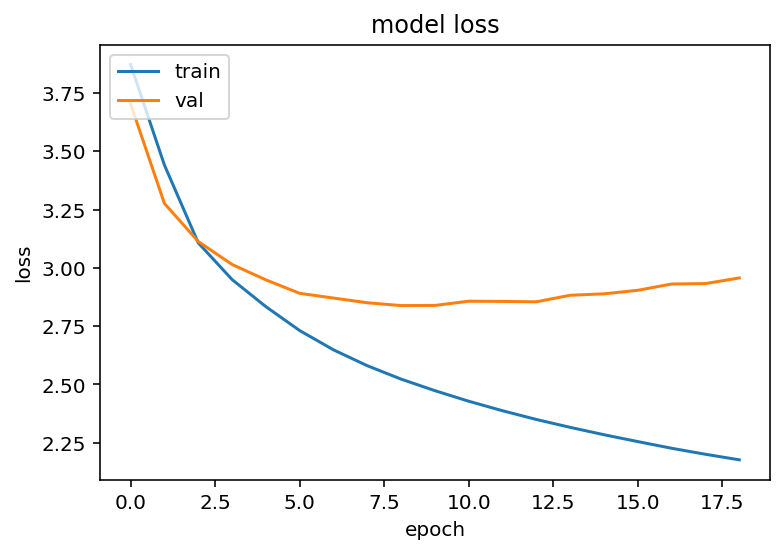

In [96]:
plt.plot(model_interval.history.history['loss'])
plt.plot(model_interval.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
from keras.losses import SparseCategoricalCrossentropy

In [69]:
SparseCategoricalCrossentropy

keras.losses.SparseCategoricalCrossentropy

In [18]:
model_interval.load_weights('models_checkpoints/weights-improvement-10-2.84.hdf5')

In [19]:
generated_vector = sample_seq([1], SEQ_LEN, model_interval, number_to_interval, 50)
generated_intervals = [number_to_interval[number] for number in generated_vector]

In [23]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20210426_003227'

In [22]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 4, 26, 0, 31, 13, 594252)

In [24]:
from_intervals_to_midi(70, generated_intervals, datetime.now().strftime("%Y%m%d_%H%M%S")+'_generated_record_intervals_tuning.mid') 